In [6]:
import pandas as pd
import numpy as np
from PIL import Image
#from wordcloud import WordCloud
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from gensim.models import Word2Vec

In [2]:
def basic_clean(string):
    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = BeautifulSoup(string, "html.parser").get_text()
    string = re.sub(r'\S+@\S+', '', string)
    string = re.sub(r'http\S+|www\S+|https\S+', '', string, flags=re.MULTILINE)
    string = re.sub(r'\d+', '', string)
    string = re.sub(r'[^\w\s]', '', string).lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in string.split()]
    string = ' '.join(lemmatized_words)
    return string

def remove_stopwords(string, extra_words=[], exclude_words=[]):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')

    #remove 'exclude_words' from stopword_list
    stopword_list=set(stopword_list)-set(exclude_words)
    
    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))

    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    
    return string_without_stopwords

    

In [3]:
df=pd.read_csv("IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
df['cleaned']=df['review'].apply(basic_clean).apply(remove_stopwords).apply(word_tokenize)
df

C:\Users\wangd\AppData\Local\Temp\ipykernel_26184\838654709.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  string = BeautifulSoup(string, "html.parser").get_text()


,review,sentiment,cleaned
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, ha, mentioned, watching, oz, e..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wa, wonderful, way, spend, time, hot..."
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, matteis, love, time, money, visually,..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,"[thought, movie, right, good, job, wasnt, crea..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,I am a Catholic taught in parochial elementary...,negative,"[catholic, taught, parochial, elementary, scho..."
49998,I'm going to have to disagree with the previou...,negative,"[im, going, disagree, previous, comment, side,..."


In [10]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df["sentiment"]=le.fit_transform(df["sentiment"])

In [14]:
print(df.iloc[:,1:])

       sentiment                                            cleaned
0              1  [one, reviewer, ha, mentioned, watching, oz, e...
1              1  [wonderful, little, production, filming, techn...
2              1  [thought, wa, wonderful, way, spend, time, hot...
3              0  [basically, family, little, boy, jake, think, ...
4              1  [petter, matteis, love, time, money, visually,...
...          ...                                                ...
49995          1  [thought, movie, right, good, job, wasnt, crea...
49996          0  [bad, plot, bad, dialogue, bad, acting, idioti...
49997          0  [catholic, taught, parochial, elementary, scho...
49998          0  [im, going, disagree, previous, comment, side,...
49999          0  [one, expects, star, trek, movie, high, art, f...

[50000 rows x 2 columns]


In [7]:
sentences = df['cleaned'].tolist()

skipgram = Word2Vec(
    sentences=sentences,
    sg=1,
    vector_size=50,
    window=5,
    min_count=1,
)

In [15]:
skipgram.wv.most_similar("good")

[('decent', 0.9120640158653259),
 ('great', 0.9055388569831848),
 ('welland', 0.9025294780731201),
 ('goodand', 0.8971324563026428),
 ('greatthe', 0.8939534425735474),
 ('bad', 0.8927534222602844),
 ('funthe', 0.8904592394828796),
 ('toothis', 0.8888054490089417),
 ('morethe', 0.8877162933349609),
 ('goodit', 0.8869320750236511)]

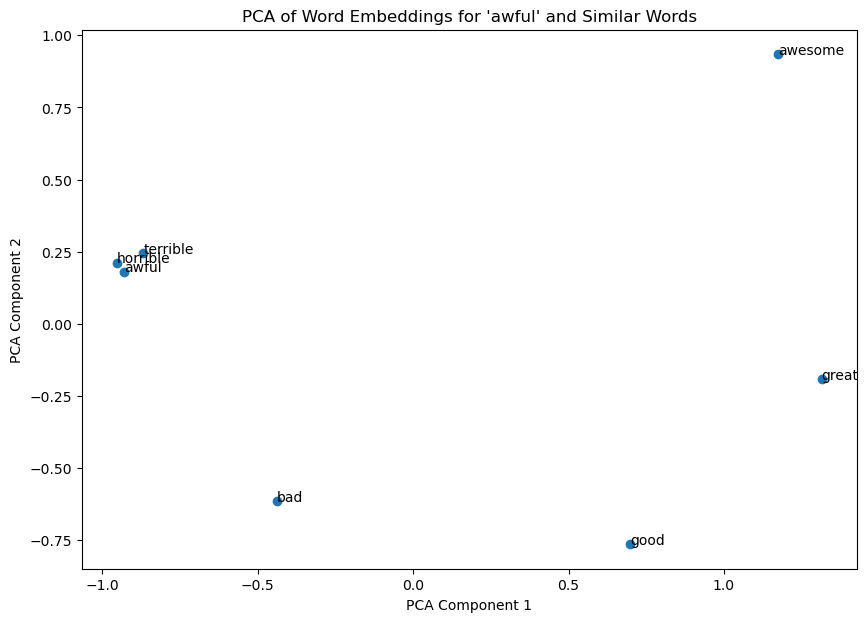

In [19]:
from sklearn.decomposition import PCA
def display_pca_scatterplot(model, word, similar_words):
    word_vectors = [model.wv[word]] + [model.wv[w] for w in similar_words]
    words = [word] + similar_words

    pca = PCA(n_components=2)
    word_vectors_pca = pca.fit_transform(word_vectors)

    plt.figure(figsize=(10, 7))
    plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1])

    for i, word in enumerate(words):
        plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

    plt.title(f"PCA of Word Embeddings for '{word}' and Similar Words")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

display_pca_scatterplot(skipgram, 'good', ['bad', 'great', 'awesome', 'terrible', 'horrible', 'awful'])

In [9]:
cbow = Word2Vec(
    sentences=sentences, 
    sg=0,
    vector_size=50,
    window=5,
    min_count=1,
)

Words similar to 'ai':
  installing: 0.8864
  forge: 0.8747
  satanism: 0.8711
  unlimited: 0.8688
  sdp: 0.8682


In [20]:
cbow.wv.most_similar("good")

[('decent', 0.8271798491477966),
 ('great', 0.8224149942398071),
 ('bad', 0.7809852957725525),
 ('nice', 0.7395712733268738),
 ('alright', 0.7387679815292358),
 ('ok', 0.7237927317619324),
 ('okay', 0.716795027256012),
 ('fine', 0.7143955230712891),
 ('cool', 0.7057197093963623),
 ('moviemost', 0.6866149306297302)]

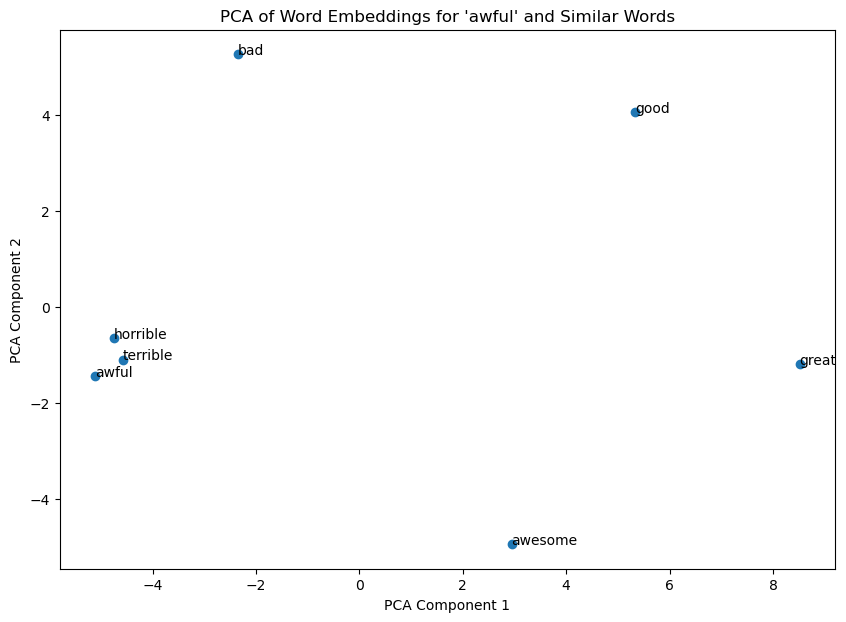

In [21]:
display_pca_scatterplot(cbow, 'good', ['bad', 'great', 'awesome', 'terrible', 'horrible', 'awful'])

In [24]:
def get_average_word2vec(tokens_list, model, vector_size):
    tokens_list = [token for token in tokens_list if token in model.wv]
    word_vecs = [model.wv[token] for token in tokens_list]
    return np.mean(word_vecs, axis=0)

In [25]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df['cleaned'].apply(lambda x: get_average_word2vec(x, skipgram, 100)).tolist()
X = np.array(X)
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      4979
           1       0.84      0.87      0.85      5021

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [26]:
X = df['cleaned'].apply(lambda x: get_average_word2vec(x, cbow, 100)).tolist()
X = np.array(X)
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      4979
           1       0.82      0.84      0.83      5021

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

